In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

import numpy as np
from itertools import product
from data import make_dataset
from client import Client
from server import Server

dataset = make_dataset("cora", root="../data")
graph = dataset[0]
linkless_graph = graph.clone()
linkless_graph.edge_index = None

## Baselines

First, let's train a MLP without any link information. This should be the lower bound of our LDP GNN performance.

In [208]:
mlp_res = np.zeros(30)
for i in range(30):
    mlp_server = Server(None, None, graph)
    log = mlp_server.fit("mlp", dataset.num_features, dataset.num_classes, hparam={"lr": 0.1, "wd": 1e-4})
    mlp_res[i] = log[np.argmin(log[:,1]),2]
print(mlp_res.mean())
print(mlp_res.std())

0.729800307219662
0.012494124203099252


Then, let's train a GCN with all the information. This is the non-private upper bound of our LDP GNN.

In [209]:
gcn_res = np.zeros(30)
for i in range(30):
    gcn_server = Server(None, None, graph)
    log = gcn_server.fit("gcn", dataset.num_features, dataset.num_classes, hparam={"lr": 0.1, "wd": 1e-4})
    gcn_res[i] = log[np.argmin(log[:,1]),2]
print(gcn_res.mean())
print(gcn_res.std())

0.865488991295443
0.005618611903046693


## Grid Search for hyper parameter tuning

In [2]:
hparam_space = {
    "delta": [0.1, 0.3, 0.5],
    "lr": [1e-4, 1e-3, 1e-2, 1e-1],
    "wd": [1e-4, 1e-3, 1e-2, 1e-1]
}

hparam_list = [dict(zip(hparam_space.keys(), values)) for values in product(*hparam_space.values())]

In [4]:
import math

num_trials = 10
min_val_loss = {}
best_hparam = {}
best_hparam_res = {}

for eps in [0.5, 1, 2, 4, 8]:
    print("Epsilon = ", eps)
    min_val_loss[eps] = math.inf
    best_hparam[eps] = None
    best_hparam_res[eps] = None
    for hparam in hparam_list:
        hparam_res = np.zeros((num_trials, 2))
        for i in range(num_trials):
            client = Client(eps=eps, delta=hparam["delta"], data=graph)
            server = Server(eps=eps, delta=hparam["delta"], data=linkless_graph)

            priv_adj, priv_deg = client.AddLDP()
            server.receive(priv_adj, priv_deg)
            server.estimate()
            log = server.fit("gcn", d=dataset.num_features, c=dataset.num_classes, hparam=hparam)
            hparam_res[i] = log[:,1].min(), log[np.argmin(log[:,1])][2] # (val_loss, test_acc)
        val_loss = hparam_res[:,0].mean()
        if val_loss < min_val_loss[eps]:
            min_val_loss[eps] = val_loss
            best_hparam_res[eps] = hparam_res
            best_hparam[eps] = hparam
    print("Best hparam is: ", best_hparam[eps], "with test accuracy", best_hparam_res[eps][:,1].mean(), "(", best_hparam_res[eps][:,1].std(), ")")

Epsilon =  0.5
Best hparam is:  {'delta': 0.5, 'lr': 0.1, 'wd': 0.0001} with test accuracy 0.737173579109063 ( 0.008313400385704958 )
Epsilon =  1
Best hparam is:  {'delta': 0.5, 'lr': 0.1, 'wd': 0.0001} with test accuracy 0.7284178187403993 ( 0.01191442054050095 )
Epsilon =  2
Best hparam is:  {'delta': 0.5, 'lr': 0.1, 'wd': 0.0001} with test accuracy 0.7284178187403995 ( 0.009758758939642748 )
Epsilon =  4
Best hparam is:  {'delta': 0.1, 'lr': 0.1, 'wd': 0.0001} with test accuracy 0.7731182795698925 ( 0.012076702925346199 )
Epsilon =  8
Best hparam is:  {'delta': 0.1, 'lr': 0.1, 'wd': 0.0001} with test accuracy 0.8669738863287251 ( 0.006113594083604417 )


## Training with best hparam

In [33]:
res = {}
num_trials = 30

for eps in [0.5, 1, 2, 4, 8]:
    hp = best_hparam[eps]
    res[eps] = np.zeros(num_trials)
    for i in range(num_trials):
        client = Client(eps=eps, delta=hp["delta"], data=graph)
        server = Server(eps=eps, delta=hp["delta"], data=linkless_graph)

        priv_adj, priv_deg = client.AddLDP()
        server.receive(priv_adj, priv_deg)
        server.estimate()
        log = server.fit("gcn", d=dataset.num_features, c=dataset.num_classes, hparam=hp)
        res[eps][i] = log[np.argmin(log[:,1])][2]

In [38]:
{i:(res[i].mean(), res[i].std()) for i in [0.5, 1, 2, 4, 8]}

{0.5: (0.732821300563236, 0.013858599916104383),
 1: (0.7291346646185356, 0.012853960355985083),
 2: (0.7253456221198157, 0.012982227126420803),
 4: (0.7777265745007681, 0.015051412086339706),
 8: (0.8649257552483361, 0.004307166583679081)}

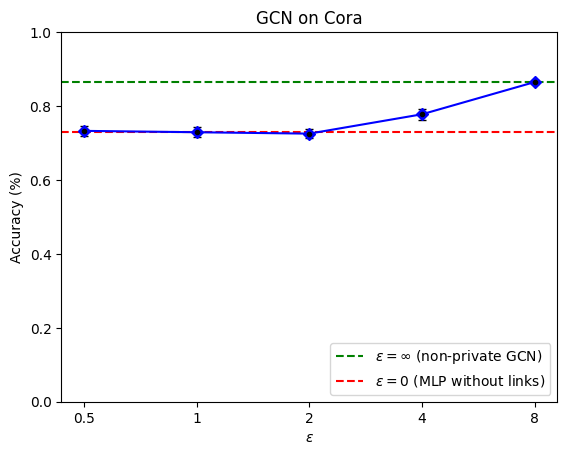

In [213]:
from matplotlib import pyplot as plt

fig = plt.figure()
plt.axhline(y = gcn_res.mean(), color = 'g', linestyle = '--')
plt.axhline(y = mlp_res.mean(), color = 'r', linestyle = '--')
plt.errorbar(["0.5", "1", "2", "4", "8"], [res[i].mean() for i in [0.5, 1, 2, 4, 8]], yerr=[res[i].std() for i in [0.5, 1, 2, 4, 8]], fmt='.k', capsize=3)
plt.plot(["0.5", "1", "2", "4", "8"], [res[i].mean() for i in [0.5, 1, 2, 4, 8]], marker="D", color="blue")

# plt.yscale("log")
plt.ylim(ymin=0, ymax=1)
plt.xlabel("$\epsilon$")
plt.ylabel("Accuracy (%)")
plt.title("GCN on Cora")
plt.legend(["$\epsilon=\infty$ (non-private GCN)","$\epsilon=0$ (MLP without links)"], loc=4)
plt.savefig("log/cora.pdf", bbox_inches='tight')